# Task B

In [49]:
!pip install spaghetti osmnx pyproj esda geopy

In [50]:
import osmnx as ox
from shapely.geometry import Point, LineString, MultiPoint
from shapely.ops import nearest_points, unary_union
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from pyproj import Transformer
from helpers.location_converter import ENtoLL84
from scipy.stats import gaussian_kde
import numpy as np
import esda
from geopandas import GeoDataFrame
import spaghetti
import seaborn as sns
from geopy.distance import geodesic

In [51]:

df2014 = pd.read_csv('../data/clean_2014.csv')
df2015 = pd.read_csv('../data/clean_2015.csv')
df2016 = pd.read_csv('../data/clean_2016.csv')
df2017 = pd.read_csv('../data/clean_2017.csv')
df2018 = pd.read_csv('../data/clean_2018.csv')
df2019 = pd.read_csv('../data/clean_2019.csv')

all_datasets = [df2014, df2015, df2016, df2017, df2018, df2019] # , df2015, df2016, df2017, df2018, df2019

## Task B.1

Plot the distribution of road accidents on your road network and visualise this. Aggregate across multiple years of accident data.

In [52]:
concat_data = pd.concat(all_datasets)

concat_data[['longitude', 'latitude']] = concat_data.apply(lambda row: pd.Series(ENtoLL84(row['Grid Ref: Easting'], row['Grid Ref: Northing'])), axis=1)

concat_data.to_csv('concat_data.csv')

/home/john_kelly_tamargo/NDA/NDACW2/taskB/helpers/location_converter.py:18: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return transform(v36, v84, vlon36, vlat36) # (longitude, latitude)


In [53]:
PLACE_OF_INTEREST = "Leeds, United Kingdom"

area = ox.geocode_to_gdf(PLACE_OF_INTEREST)

### Spatial Plots

Text(0.5, 1.0, 'Road Accidents in Leeds')

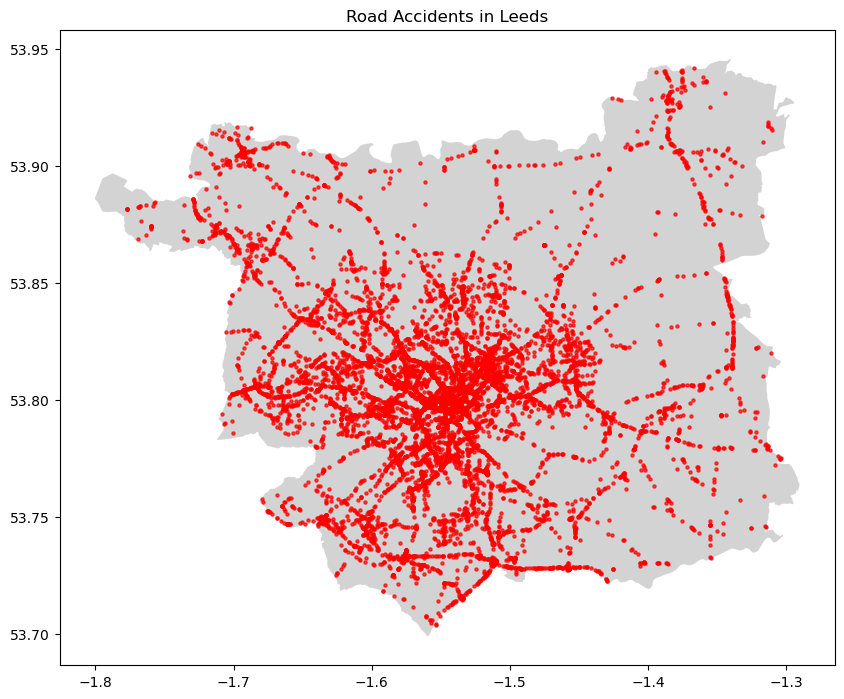

In [54]:
# Without Roads
accidents_gdf = gpd.GeoDataFrame(concat_data, geometry = gpd.points_from_xy(concat_data.longitude, concat_data.latitude))
accidents_gdf.crs = "EPSG:4326"

fig, ax = plt.subplots(figsize=(10, 10))
area.plot(ax=ax, facecolor='lightgray')

accidents_gdf.plot(ax=ax, markersize=5, color='red', alpha=0.7)

ax.set_title("Road Accidents in Leeds")


Text(0.5, 1.0, 'Road Accidents in Leeds')

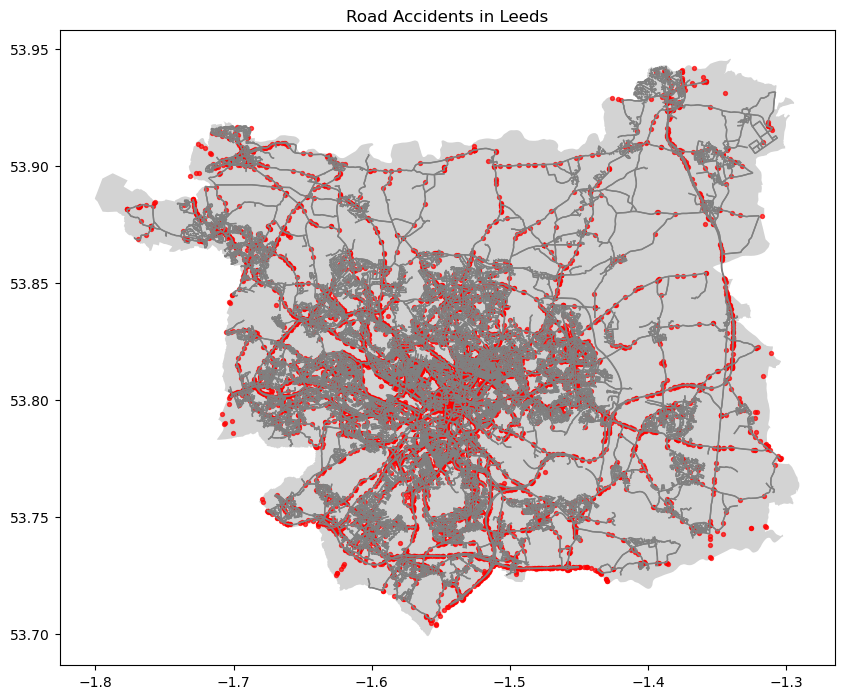

In [55]:
graph_with_roads = ox.graph_from_place(PLACE_OF_INTEREST, network_type='drive')
fig, ax = plt.subplots(figsize=(10, 10))

accidents_gdf = gpd.GeoDataFrame(concat_data, geometry = gpd.points_from_xy(concat_data.longitude, concat_data.latitude))
accidents_gdf.crs = "EPSG:4326"

area.plot(ax=ax, facecolor='lightgray')

# Plot the roads
edges = ox.graph_to_gdfs(graph_with_roads, nodes=False, edges=True)
edges.plot(ax=ax, linewidth=1, edgecolor='gray')

accidents_gdf.plot(ax=ax, markersize=8, color='red', alpha=0.7)

ax.set_title("Road Accidents in Leeds")

### Density Plots

Text(0.5, 1.0, 'Density of Road Accidents in Leeds')

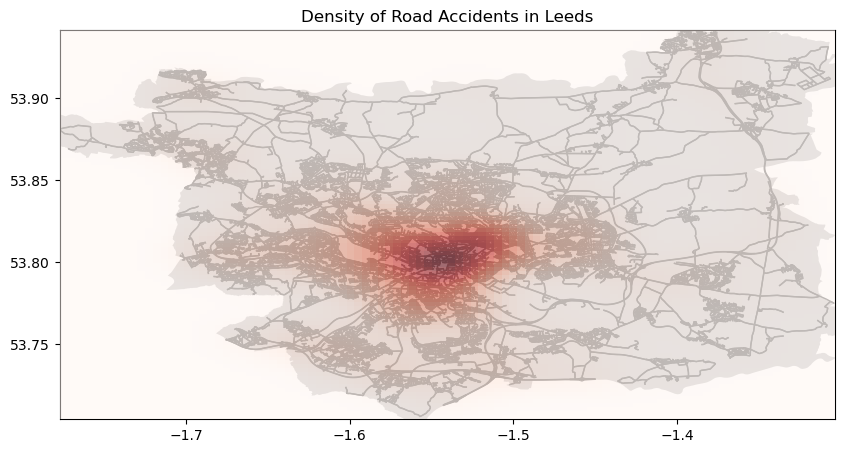

In [56]:
accidents_gdf = gpd.GeoDataFrame(concat_data, geometry=gpd.points_from_xy(concat_data.longitude, concat_data.latitude))
accidents_gdf.crs = "EPSG:4326"
accidents_gdf = accidents_gdf.to_crs(area.crs)

x = accidents_gdf.geometry.x
y = accidents_gdf.geometry.y
kde = gaussian_kde([x, y])
xx, yy = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
f = np.reshape(kde(positions).T, xx.shape)

fig, ax = plt.subplots(figsize=(10, 10))

area.plot(ax=ax, color='lightgray', zorder=1)
edges = ox.graph_to_gdfs(graph_with_roads, nodes=False, edges=True)
edges.plot(ax=ax, linewidth=1, edgecolor='gray', zorder=2)

ax.imshow(np.rot90(f), cmap='Reds', extent=[x.min(), x.max(), y.min(), y.max()], zorder=3, alpha=0.5)


ax.set_title("Density of Road Accidents in Leeds")


## Task B.2
- Investigate whether a high number of accidents on one road correlates with a high number on connecting roads. 
- Calculate the k-function and the Moran's I values for the above spatial graph.

K-Values

In [57]:
# # Attempt 4
center_point = (53.8008, -1.5491)

dist = 600

north = geodesic(meters=dist).destination(center_point, bearing=0).latitude
south = geodesic(meters=dist).destination(center_point, bearing=180).latitude
east = geodesic(meters=dist).destination(center_point, bearing=90).longitude
west = geodesic(meters=dist).destination(center_point, bearing=270).longitude


bbox = (north, south, east, west)


graph = ox.graph_from_bbox(north=bbox[0], south=bbox[1], east=bbox[2], west=bbox[3], network_type='drive')

roads_geodataframe = ox.graph_to_gdfs(graph, nodes=False, edges=True)

leeds_center_network = spaghetti.Network(in_data=roads_geodataframe)

/tmp/ipykernel_5645/185787660.py:15: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.
  graph = ox.graph_from_bbox(north=bbox[0], south=bbox[1], east=bbox[2], west=bbox[3], network_type='drive')


ACCIDENT POINTS DONE
ACCIDENT GDF DONE


/home/john_kelly_tamargo/miniconda3/envs/nda/lib/python3.12/site-packages/spaghetti/network.py:3414: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  pts = [cg.shapes.Point((p.x, p.y)) for p in pts_objs]
/home/john_kelly_tamargo/miniconda3/envs/nda/lib/python3.12/site-packages/spaghetti/util.py:583: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  return cg.Chain([cg.Point(_vcoords[v]) for v in _vs] if _vcoords else _vs)
/home/john_kelly_tamargo/miniconda3/envs/nda/lib/python3.12/site-packages/libpysal/cg/shapes.py:1025: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  self._bounding_box = Rectangle(


SNAPPED DONE
POINT PATTERN DONE
 KRES DONE
Density of points in the network (lambda): 1901.7155683426508
Distances at which density is measured:
[0.         0.00056642 0.00113283 0.00169925 0.00226567 0.00283209
 0.0033985  0.00396492 0.00453134 0.00509775 0.00566417 0.00623059
 0.00679701 0.00736342 0.00792984 0.00849626 0.00906267 0.00962909
 0.01019551 0.01076193 0.01132834 0.01189476 0.01246118 0.01302759
 0.01359401 0.01416043 0.01472685 0.01529326 0.01585968 0.0164261
 0.01699251 0.01755893 0.01812535 0.01869177 0.01925818 0.0198246
 0.02039102 0.02095744 0.02152385 0.02209027 0.02265669 0.0232231
 0.02378952 0.02435594 0.02492236 0.02548877 0.02605519 0.02662161
 0.02718802 0.02775444]
DONE


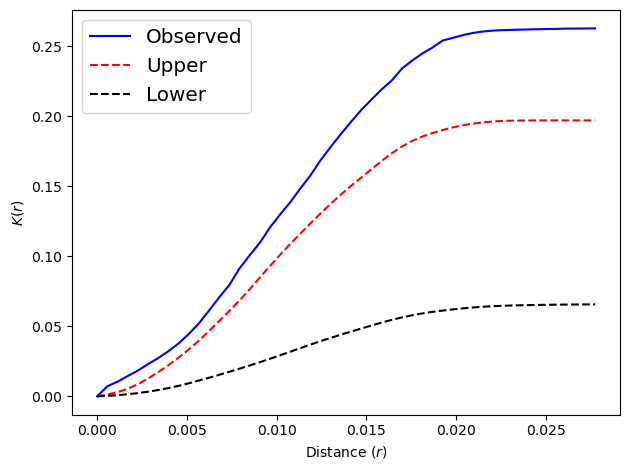

In [58]:
accidents_points = [Point(xy) for xy in zip(concat_data['longitude'], concat_data['latitude'])]
print('ACCIDENT POINTS DONE')
accidents_gdf = gpd.GeoDataFrame(geometry=accidents_points, crs="EPSG:4326")
accidents_gdf = accidents_gdf.cx[west:east, south:north]
accidents_gdf = accidents_gdf.to_crs(roads_geodataframe.crs)


print('ACCIDENT GDF DONE')
leeds_center_network.snapobservations(accidents_gdf, 'accidents')
print('SNAPPED DONE')

accidents_pointpat = leeds_center_network.pointpatterns['accidents']
print('POINT PATTERN DONE')


kres = leeds_center_network.GlobalAutoK(
    pointpattern=accidents_pointpat,
    nsteps=50,
    permutations=50
)
print(' KRES DONE')
kres.lam
kres.xaxis
kres.observed
kres.upperenvelope
kres.lowerenvelope
kres.sim

print(f"Density of points in the network (lambda): {kres.lam}")

print(f"Distances at which density is measured:\n{kres.xaxis}")
print('DONE')
fig, ax = plt.subplots()

ax.plot(kres.xaxis, kres.observed, "b-", label="Observed")
ax.plot(kres.xaxis, kres.upperenvelope, "r--", label="Upper")
ax.plot(kres.xaxis, kres.lowerenvelope, "k--", label="Lower")

ax.legend(loc="best", fontsize="x-large")
ax.set_xlabel("Distance $(r)$")
ax.set_ylabel("$K(r)$")

fig.tight_layout()

Moran's I

In [59]:
# Get count of points per network edge: a dictionary from each edge to the crime count on that edge
counts = leeds_center_network.count_per_link(accidents_pointpat.obs_to_arc, graph=False)

In [60]:
weights = leeds_center_network.w_network

In [61]:
# Get the edges included in the weights matrix: an enumerator for a list of edges
edges = weights.neighbors.keys()
# Construct an array of the counts values per edge in the same order as
# the weights matrix, with 0.0 where no counts recorded
values = [counts[edge] if edge in counts.keys () else 0. \
    for index, edge in enumerate(edges)]

In [62]:
moran = esda.moran.Moran(values, weights)
moran.I

0.1948797079700008

In [63]:
moran.p_sim

0.001

In [64]:
moran.EI
moran.EI_sim

print(moran.EI)

-0.0007782101167315176


/home/john_kelly_tamargo/miniconda3/envs/nda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, "Moran's I")

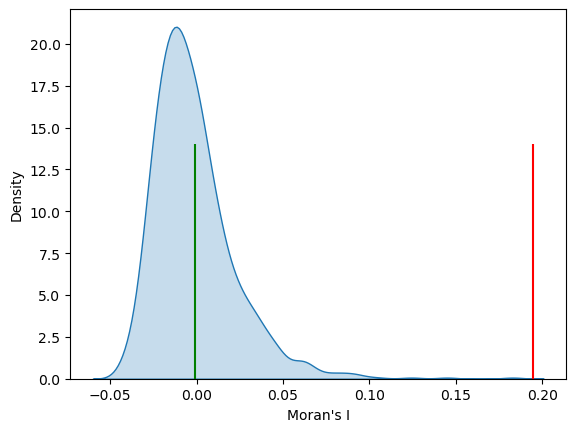

In [65]:
sns.kdeplot(moran.sim, fill=True) # Moran's I distribution
plt.vlines(moran.I, 0, 14, color='r') # Moran's I
plt.vlines(moran.EI, 0,14, color='g') # Expected Moran's I
plt.xlabel("Moran's I")

Expected Moran's I: -0.0007782101167315176
Actual Moran's I: 0.1948797079700008


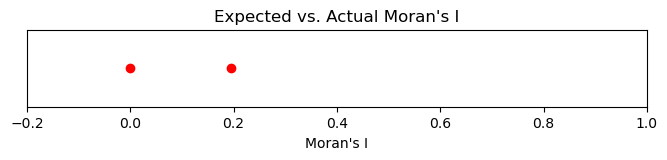

In [66]:
# Calculate the expected Moran's I under complete spatial randomness
expected_I = -1/(len(values)-1)
print(f"Expected Moran's I: {expected_I}")
print(f"Actual Moran's I: {moran.I}")

# Plot the expected and actual values
plt.figure(figsize=(8, 1))
plt.plot([expected_I, moran.I], [0, 0], 'ro')
plt.xlim(-0.2, 1)
plt.xlabel("Moran's I")
plt.yticks([])
plt.title("Expected vs. Actual Moran's I")
plt.show()

## Taskb.3
Investigate whether accidents happen nearer to intersections or partway along roads. 
Consider this as asking at what fraction of the road length away from the nearest 
intersection do accidents typically occur


In [67]:
def get_nearest_street(graph, accident_point):
    return ox.distance.nearest_edges(graph, accident_point.x, accident_point.y, return_dist=True)

In [68]:
def get_road_ends(nearest_street):
    (u, v, key), dist = nearest_street
    edge_data = edges.loc[(u, v, key)]
    street_geom = edge_data.geometry

    if isinstance(street_geom, LineString):
        start, end = street_geom.coords[0], street_geom.coords[-1]
        return start, end
    else:
        print('ISN\'T WORKING')

In [69]:
def get_distances(start, end, accident_point):
    start_point = Point(start)
    end_point = Point(end)

    distance_to_start = geodesic((accident_point.y, accident_point.x), (start_point.y, start_point.x)).meters
    distance_to_end = geodesic((accident_point.y, accident_point.x), (end_point.y, end_point.x)).meters
    return distance_to_start, distance_to_end

In [70]:
def get_fraction_of_distance_from_intersection(graph, accident_point):
    nearest_street = get_nearest_street(graph, accident_point)
    start, end = get_road_ends(nearest_street)
    distance_to_start, distance_to_end = get_distances(start, end, accident_point)

    if distance_to_start > distance_to_end:
        closer = distance_to_end
        farther = distance_to_start
    else:
        farther = distance_to_end
        closer = distance_to_start

    return closer, farther


In [71]:
def my_apply_2(row, graph):
    accident_point = Point(row['longitude'], row['latitude'])
    return get_fraction_of_distance_from_intersection(graph, accident_point)

In [72]:
graph = ox.graph_from_place(PLACE_OF_INTEREST, network_type='drive')
nodes, edges = ox.graph_to_gdfs(graph, nodes=True, edges=True)


concat_data[['Closer', 'Farther']] = concat_data.apply(my_apply_2, graph = graph, axis=1, result_type='expand')

In [ ]:
def get_fraction(closer, farther):
    return closer/farther

def apply_fraction(row):
    closer = row['Closer']
    farther = row['Farther']
    return get_fraction(closer, farther)

concat_data['Fraction Distance'] = concat_data.apply(apply_fraction, axis=1, result_type='expand')

In [ ]:
print(concat_data['Fraction Distance'].mean())

0.3106005458373089


In [ ]:
total_distance = 0

total_distance += concat_data['Closer'].sum()
total_distance += concat_data['Farther'].sum()

num_rows = len(concat_data)

print(f'{round(total_distance/num_rows, 2)} meters')

326.03 meters


/home/john_kelly_tamargo/miniconda3/envs/nda/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Density')

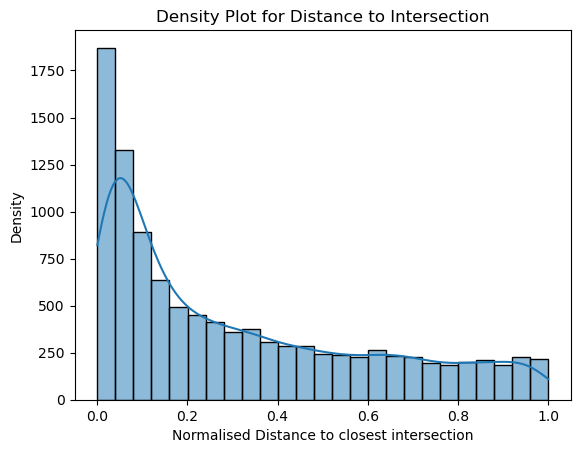

In [ ]:
data_points = concat_data['Fraction Distance']

sns.histplot(data_points, kde = True)

plt.title('Density Plot for Distance to Intersection')
plt.xlabel('Normalised Distance to closest intersection')
plt.ylabel('Density')